In [1]:
import pandas as pd

df = pd.read_csv('unified_genotypes_preprocessed_final_v2 - unified_genotypes_preprocessed_final_v2.csv')

In [2]:
df = df.drop(columns=['patient_id', 'risk'])
# df = df.drop(columns=[col for col in df.columns if col.startswith('chrX') or col.startswith('chrY')])
df.head()

,group,chr1_826893,chr1_941119,chr1_952421,chr1_953259,chr1_953279,chr1_961945,chr1_962184,chr1_979847,chr1_1013466,...,chrX_143629567,chrX_145823364,chrX_150762633,chrX_151700795,chrX_152850288,chrX_153776089,chrX_154412069,chrX_156023167,chrX_156023436,vaccination
0,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,0,1,1,1,1,0.0
1,0,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,0,0,0.0
2,1,1,1,1,1,1,1,1,0,0,...,2,2,2,2,2,2,2,1,1,0.0
3,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,0,0,0.0
4,1,0,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,1,1,0.0


In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['group'])
y = df['group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess(X_train, X_test, n_features_to_select=20, plot_importance=False):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    selector = XGBClassifier(random_state=42).fit(X_train, y_train)
    importances = selector.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    })
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    
    top_features = feature_importance_df['feature'][:n_features_to_select]
    X_train = X_train[:, top_features.index]
    X_test = X_test[:, top_features.index]

    if plot_importance:
        n_to_plot = min(n_features_to_select, 20)
        plt.figure(figsize=(10, 8))
        plt.barh(feature_importance_df['feature'][:n_to_plot], feature_importance_df['importance'][:n_to_plot])
        plt.gca().invert_yaxis()
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.title(f'Top {n_to_plot} Features by Importance')
        plt.show()

    return X_train, X_test

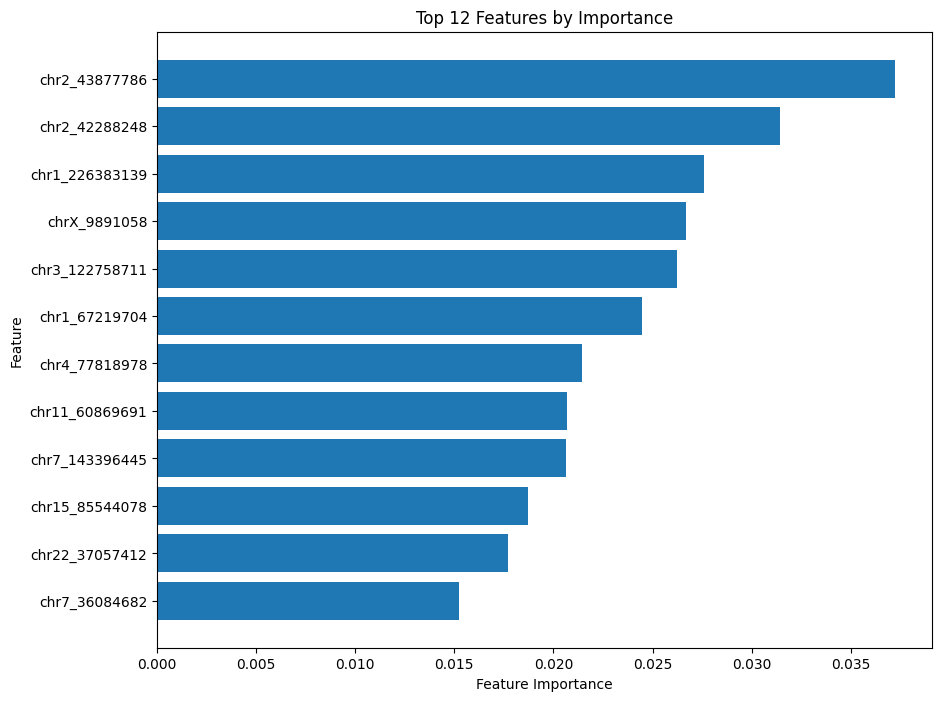

In [5]:
X_train, X_test = preprocess(X_train, X_test, n_features_to_select=12, plot_importance=True)

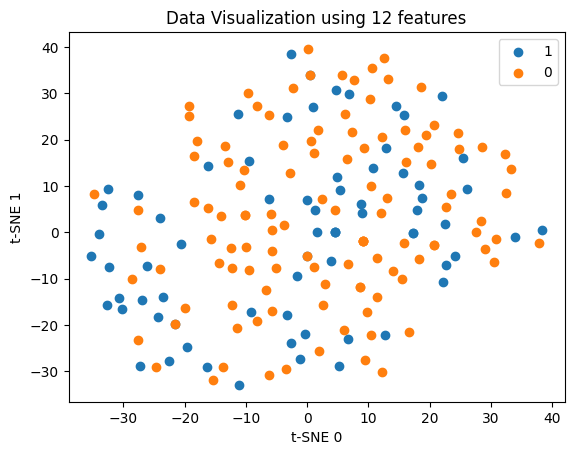

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)

for label in y_train.unique():
    plt.scatter(X_train_tsne[y_train == label, 0], X_train_tsne[y_train == label, 1], label=label)
plt.xlabel('t-SNE 0')
plt.ylabel('t-SNE 1')
plt.title(f'Data Visualization using {X_train.shape[1]} features')
plt.legend()
plt.show()

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

def svm_model_and_params():
    model = SVC(random_state=42)
    params = {
        'C': [1, 10, 100],
        'gamma': [0.1, 0.01, 0.001],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }
    return model, params


def knn_model_and_params():
    model = KNeighborsClassifier()
    params = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
    return model, params


def rf_model_and_params():
    model = RandomForestClassifier(random_state=42)
    params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'criterion': ['gini', 'entropy']
    }
    return model, params


def xgb_model_and_params():
    model = XGBClassifier(random_state=42)
    params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.3]
    }
    return model, params


def nb_model_and_params():
    model = GaussianNB()
    params = {}
    return model, params

In [8]:
from sklearn.model_selection import GridSearchCV

model, param_grid = xgb_model_and_params()
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]})

Accuracy: 0.7872
Precision: 0.8750
Recall: 0.4375
Specificity: 0.9677
F1: 0.5833


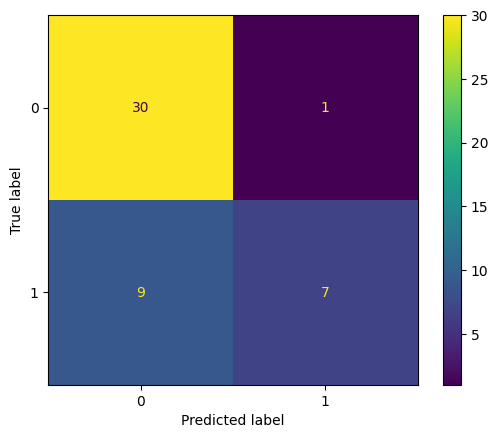

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = grid_search.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_pred):.4f}')
print(f'Specificity: {recall_score(y_test, y_pred, pos_label=0):.4f}')
print(f'F1: {f1_score(y_test, y_pred):.4f}')

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot()
plt.show()

In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV

def evaluate_all_models(X_train, X_test, y_train, y_test):
    all_models = {
        'NB': nb_model_and_params(),
        'SVM': svm_model_and_params(),
        'KNN': knn_model_and_params(),
        'RF': rf_model_and_params(),
        'XGB': xgb_model_and_params(),
    }

    df_results = pd.DataFrame()
    for model_name, (model, param_grid) in all_models.items():
        grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        specificity = recall_score(y_test, y_pred, pos_label=0)
        f1 = f1_score(y_test, y_pred)

        new_row = pd.DataFrame({
            'Model': [model_name],
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'Specificity': [specificity],
            'F1 score': [f1],
            'Best parameters': [grid_search.best_params_]
        })
        df_results = pd.concat([df_results, new_row], ignore_index=True)

    return df_results.round(4)

In [11]:
df_results = evaluate_all_models(X_train, X_test, y_train, y_test)
df_results.to_csv('results.csv', index=False)

def print_best_metrics(df_results):
    best_accuracy = {
        'model': df_results.loc[df_results['Accuracy'].idxmax()]['Model'],
        'metric': df_results['Accuracy'].max()
    }
    best_precision = {
        'model': df_results.loc[df_results['Precision'].idxmax()]['Model'],
        'metric': df_results['Precision'].max()
    }
    best_recall = {
        'model': df_results.loc[df_results['Recall'].idxmax()]['Model'],
        'metric': df_results['Recall'].max()
    }
    best_specificity = {
        'model': df_results.loc[df_results['Specificity'].idxmax()]['Model'],
        'metric': df_results['Specificity'].max()
    }
    best_f1 = {
        'model': df_results.loc[df_results['F1 score'].idxmax()]['Model'],
        'metric': df_results['F1 score'].max()
    }

    print(f'Best accuracy ({best_accuracy["model"]}): {best_accuracy["metric"]:.4f}')
    print(f'Best precision ({best_precision["model"]}): {best_precision["metric"]:.4f}')
    print(f'Best recall ({best_recall["model"]}): {best_recall["metric"]:.4f}')
    print(f'Best specificity ({best_specificity["model"]}): {best_specificity["metric"]:.4f}')
    print(f'Best F1 score ({best_f1["model"]}): {best_f1["metric"]:.4f}')

print_best_metrics(df_results)
df_results

Best accuracy (XGB): 0.7872
Best precision (XGB): 0.8750
Best recall (NB): 0.4375
Best specificity (XGB): 0.9677
Best F1 score (XGB): 0.5833


,Model,Accuracy,Precision,Recall,Specificity,F1 score,Best parameters
0,NB,0.6383,0.4667,0.4375,0.7419,0.4516,{}
1,SVM,0.6170,0.4286,0.3750,0.7419,0.4000,"{'C': 1, 'gamma': 0.1, 'kernel': 'sigmoid'}"
2,KNN,0.7660,0.7778,0.4375,0.9355,0.5600,"{'metric': 'manhattan', 'n_neighbors': 9, 'wei..."
3,RF,0.7021,0.6250,0.3125,0.9032,0.4167,"{'criterion': 'entropy', 'max_depth': 5, 'n_es..."
4,XGB,0.7872,0.8750,0.4375,0.9677,0.5833,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est..."
